In [1]:
from rtma.imports import *
from rtma.core import *
from rtma.objects import *
from rtma.signal import *
from rtma.fft import *
from rtma.stft import *
from rtma.sine_model import *

In [2]:
from pathlib import Path

In [3]:
import librosa as lr

In [4]:
path = Path('~/data/recorded_sounds/stairway_to_heaven_intro.mp3').expanduser()
x, sr = lr.load(path, sr=None)
x.shape, sr

/home/john/miniconda3/envs/rtma/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


((643919,), 48000)

In [5]:
x, _ = lr.effects.trim(x)
x = x[:sr*2]
x.shape

(96000,)

In [6]:
s = Signal("data/E_octaves_both.wav")
s.x = x
s.sample_rate = sr
s.filename = path.name

In [7]:
s.duration

2.0

In [8]:
s.play()

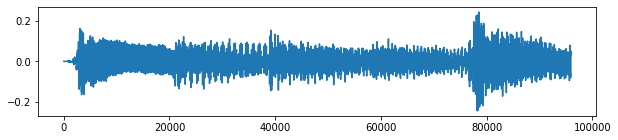

In [9]:
s.plot()

In [10]:
sr/100

480.0

In [11]:
480 * 4

1920

In [12]:
hop_size = 480  # 10ms
frame_size = hop_size * 5 # 40ms 
fft_size = 4096
i = 100

In [13]:
hop_size, frame_size

(480, 2400)

(204,
 Analysis(Signal("stairway_to_heaven_intro.mp3"), frame_size=2400, hop_size=480))

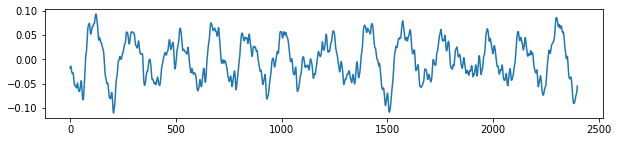

In [14]:
a = Analysis(s, frame_size=frame_size, hop_size=hop_size)
frames = list(a.frames)
frames[i].plot()
len(frames), a

In [15]:
sa = SpectralAnalysis(s, 
                      fft_size=fft_size,
                      window_name='hamming',
                      frame_size=frame_size, 
                      hop_size=hop_size)

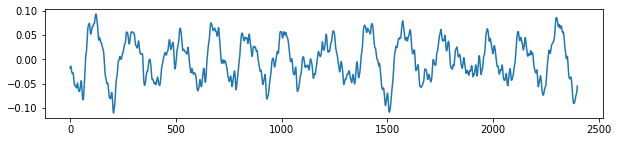

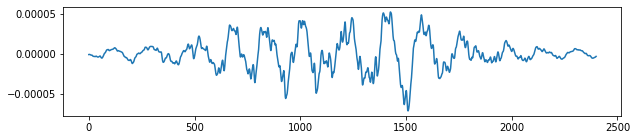

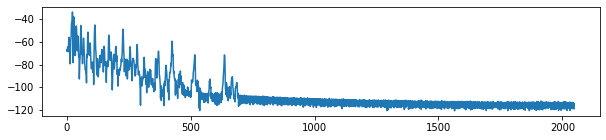

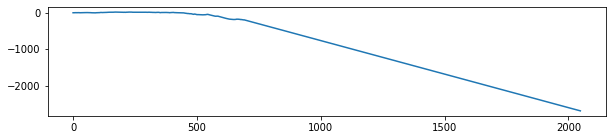

In [16]:
frames = list(sa.frames)
sframes = list(sa.spectral_frames)
sf = sframes[i]
sf.frame.plot()
sf.plot()
sf.plot_magnitudes()
sf.plot_phases();

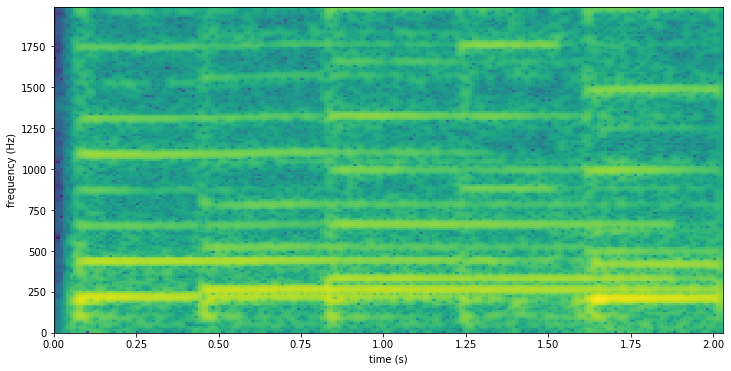

In [17]:
sa.plot_magnitudes(2000)

In [18]:
frame_size

2400

In [19]:
sma = SineModelAnalysis(s, 
                        fft_size=fft_size,
                        window_name='hamming',
                        frame_size=frame_size,
                        hop_size=hop_size,
                        peak_threshold=-80,
                        freq_dev_offset=5,
                        freq_dev_slope=0.001)

In [20]:
sma_frames = list(sma.sine_model_frames)
len(sma_frames)

204

In [21]:
len(sma.tracks)

108

In [22]:
pframes = list(sma.peak_frames)

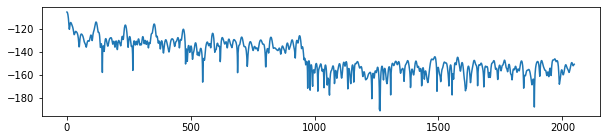

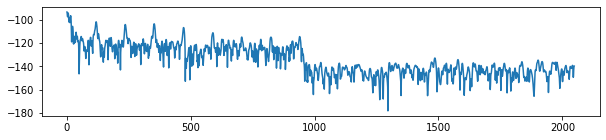

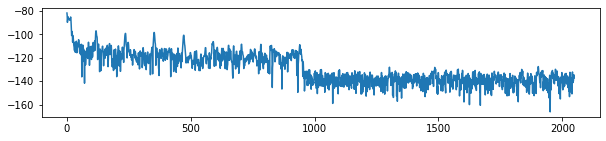

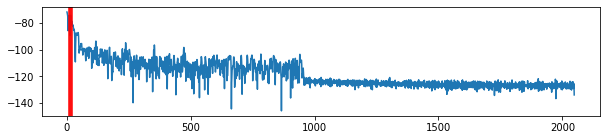

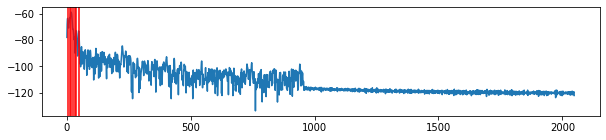

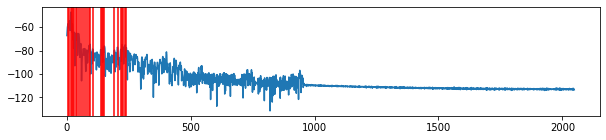

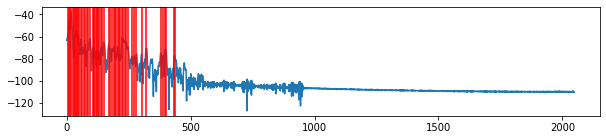

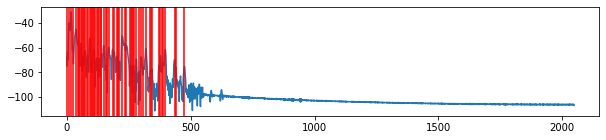

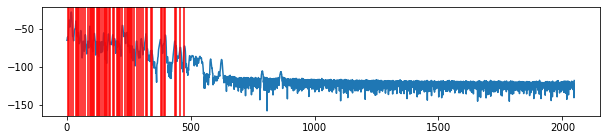

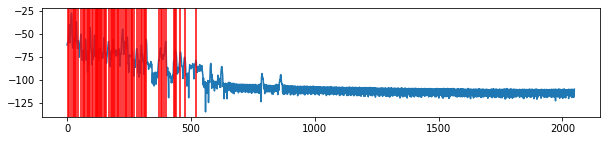

In [23]:
for pf in pframes[:10]:
    pf.plot_peaks()

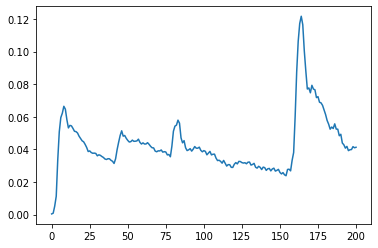

In [24]:
rms = lr.feature.rms(x, frame_length=frame_size, hop_length=hop_size)[0]
plt.plot(rms)

array([  8,  46,  83, 164])

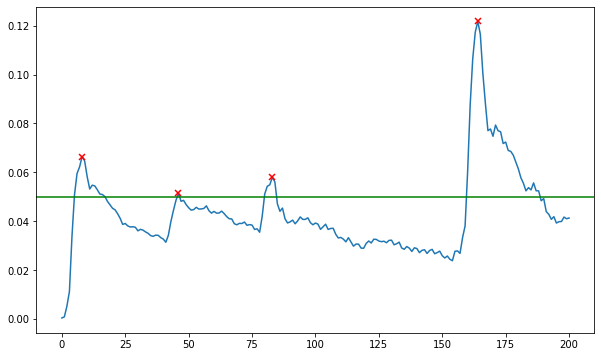

In [25]:
t = 0.05
peak_i = detect_peaks(rms, thresh=t)
peak_i = peak_i[[0, 2, 3, 4]]
plot_peaks(rms, peak_i, t=t)
peak_i

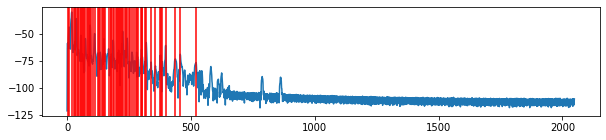

In [26]:
pframes[10].plot_peaks()

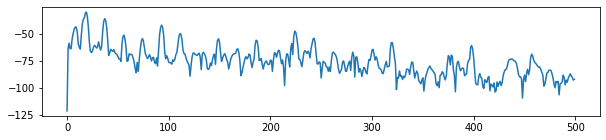

In [27]:
sframes = list(sma.spectral_frames)
sf = sframes[10]
plot(sf.magnitudes[:500])

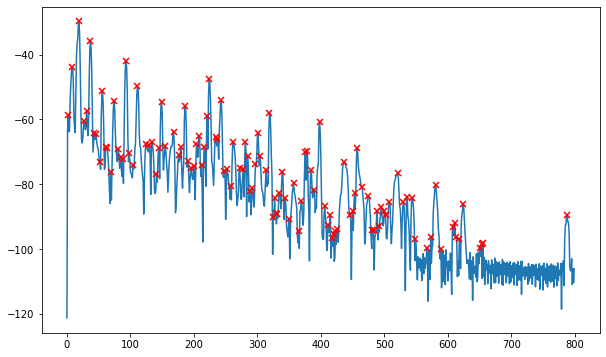

In [28]:
m = sf.magnitudes[:800]
peak_i = detect_peaks(m, -100)
plot_peaks(m, peak_i)

In [29]:
ipeak_i, ipeak_m = interpolate_peaks(m, peak_i)
ipeak_f = ipeak_i * sr / fft_size
peaks = [Peak(f,m,0) for f,m in zip(ipeak_f, ipeak_m)]

In [30]:
len(peaks)

115

In [31]:
def get_harmonics(peaks, f0):
    if not peaks: return [], np.array([])
    
    freqs = np.array([p.frequency for p in peaks])
    harms = []
    errs = []
    for i in range(1, 11):
        f = f0 * i
        diffs = f - freqs
        idx = np.argmin(abs(diffs))
        pf = freqs[idx]
        harms.append((i, f, pf))
        errs.append(diffs[idx])
    return harms, np.array(errs)

In [32]:
harms, errs = get_harmonics(peaks, 220)
harms, errs

([(1, 220, 218.69573123867457),
  (2, 440, 434.811277347156),
  (3, 660, 653.3376045778674),
  (4, 880, 868.3868505516975),
  (5, 1100, 1090.0070658359696),
  (6, 1320, 1304.4548749189928),
  (7, 1540, 1519.8900610851676),
  (8, 1760, 1744.008750024576),
  (9, 1980, 1964.3638507002718),
  (10, 2200, 2183.6650288097367)],
 array([ 1.3043,  5.1887,  6.6624, 11.6131,  9.9929, 15.5451, 20.1099,
        15.9912, 15.6361, 16.335 ]))

In [33]:
hfs = [h[2] for h in harms]
f0 = (np.array(hfs) / np.arange(1, 11)).mean()
f0

217.8145241358608

In [34]:
harms, errs = get_harmonics(peaks, f0)
harms, errs

([(1, 217.8145241358608, 218.69573123867457),
  (2, 435.6290482717216, 434.811277347156),
  (3, 653.4435724075825, 653.3376045778674),
  (4, 871.2580965434432, 868.3868505516975),
  (5, 1089.072620679304, 1090.0070658359696),
  (6, 1306.887144815165, 1304.4548749189928),
  (7, 1524.7016689510256, 1519.8900610851676),
  (8, 1742.5161930868865, 1744.008750024576),
  (9, 1960.3307172227474, 1964.3638507002718),
  (10, 2178.145241358608, 2183.6650288097367)],
 array([-0.8812,  0.8178,  0.106 ,  2.8712, -0.9344,  2.4323,  4.8116,
        -1.4926, -4.0331, -5.5198]))

In [35]:
hfs = [h[2] for h in harms]
f0 = (np.array(hfs) / np.arange(1, 11)).mean()
f0

217.8145241358608

In [36]:
t = -100
f0 = 220

f0s = []
for i, sf in enumerate(sframes):
    mags = sf.magnitudes
    peak_i = detect_peaks(mags, -100)
    ipeak_i, ipeak_m = interpolate_peaks(mags, peak_i)
    ipeak_f = ipeak_i * sr / fft_size
    peaks = [Peak(f,m,0) for f,m in zip(ipeak_f, ipeak_m)]
    
    harms, errs = get_harmonics(peaks, f0)
    
    if len(harms) > 5:
        idxs = [h[0] for h in harms]
        hfs = [h[2] for h in harms]
        mean_f0 = (np.array(hfs) / np.array(idxs)).mean()
        if abs(mean_f0 - f0) < 10:
#             print(i, len(harms), mean_f0)
            f0s.append(mean_f0)
        else:
            f0s.append(np.nan)
        
            
    else:
        f0s.append(np.nan)

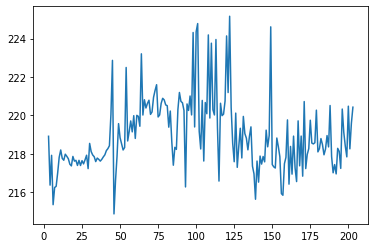

In [37]:
plt.plot(f0s)